In [2]:
import numpy as np
import pandas as pd
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import warnings
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
%matplotlib inline

# Settings

In [3]:
dataset_learn = 'sherlock'
dataset_test = 'FNL'

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
path = base_path + '/data'
thres = 0.01
nR = 122

learn_nsubj = 16
learn_wsize = 30
learn_nT = 1924

test_nsubj = 35
test_wsize = 23
test_nT = 1336

print('Across-dataset prediction')

learn_wsize = learn_wsize
test_wsize = test_wsize
print('  model learn from = '+str(dataset_learn)+' win'+str(learn_wsize))
print('  model testing    = '+str(dataset_test)+' win'+str(test_wsize))

Across-dataset prediction
  model learn from = sherlock win30
  model testing    = FNL win23


# Load Behavioral Data

In [4]:
# load valence
valence_learn = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/sherlock_valence.mat')['sliding_beh']
valence_learn = np.squeeze(valence_learn)

valence_test = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/FNL_valence.mat')['sliding_beh']
valence_test = np.squeeze(valence_test)

# load arousal
arousal_learn = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/sherlock_arousal.mat')['sliding_beh']
arousal_learn = np.squeeze(arousal_learn)

arousal_test = scipy.io.loadmat(path + '/beh/preprocessed/group_average/conv_slidingBeh/FNL_arousal.mat')['sliding_beh']
arousal_test = np.squeeze(arousal_test)

print('model learn: valence shape' + str(valence_learn.shape))
print('model learn: arousal shape' + str(arousal_learn.shape))

print('model test: valence shape' + str(valence_test.shape))
print('model test: arousal shape' + str(arousal_test.shape))

model learn: valence shape(1894,)
model learn: arousal shape(1894,)
model test: valence shape(1341,)
model test: arousal shape(1341,)


# Load Brain Data

In [5]:
import mat73

# Load Sherlock
dynFC_learn = mat73.loadmat(path + '/brain/' + dataset_learn + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
# zscore per feature
dynFC_learn = scipy.stats.zscore(dynFC_learn,2,nan_policy='omit') 
print('  model learn: brain entire feature shape '+str(dynFC_learn.shape))

# Load FNL
dynFC_test = mat73.loadmat(path + '/brain/' + dataset_test + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
# zscore per feature
dynFC_test = scipy.stats.zscore(dynFC_test,2,nan_policy='omit') 
print('  model test: brain entire feature shape '+str(dynFC_test.shape))

  model learn: brain entire feature shape (16, 7381, 1894)
  model test: brain entire feature shape (35, 7381, 1341)


# Valence

In [7]:
filepath = base_path + '/results/CPM/within/sherlock/sliding_valence.mat'
pos_feat = scipy.io.loadmat(filepath)['pos_feat']
neg_feat = scipy.io.loadmat(filepath)['neg_feat']
pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
for i1 in range(nR):
    for i2 in range(nR):
        if pos_feat[i1,i2]<1:
            pos_feat[i1,i2]=0
        if neg_feat[i1,i2]<1:
            neg_feat[i1,i2]=0
print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
all_feat = pos_feat+neg_feat
featid = []
ii = -1
for i1 in range(nR-1):
    for i2 in range(i1+1,nR):
        ii=ii+1
        if all_feat[i1,i2]==1:
            featid.append(ii)

 #pos = 493 , #neg = 31


In [8]:
dynFC_learn = dynFC_learn[:,featid,:]
dynFC_test = dynFC_test[:,featid,:]
print('  model learn: brain selected feature shape '+str(dynFC_learn.shape))
print('  model test : brain selected feature shape '+str(dynFC_test.shape))

  model learn: brain selected feature shape (16, 524, 1894)
  model test : brain selected feature shape (35, 524, 1341)


In [9]:
train_feat = np.transpose(dynFC_learn,(1,0,2))
train_feat = np.reshape(train_feat,(train_feat.shape[0],train_feat.shape[1]*train_feat.shape[2]))

train_valence = []
for sub in range(learn_nsubj):
    train_valence.append(valence_learn)
train_valence = np.asarray(train_valence)
train_valence = np.reshape(train_valence, (train_valence.shape[0])*train_valence.shape[1])

# if several TRs are removed
rmtr_train = []
for tm in range(train_feat.shape[1]):
    if np.all(np.isnan(train_feat[:,tm])):
        rmtr_train.append(tm)
rmtr_train = np.asarray(rmtr_train)
if len(rmtr_train)>0:
    train_feat = np.delete(train_feat,rmtr_train,1)
    train_valence = np.delete(train_valence,rmtr_train,0)

In [10]:
nanidx = []
for ft in range(train_feat.shape[0]):
    if np.any(np.isnan(train_feat[ft,:])):
        nanidx.append(ft)
for subj in range(dynFC_test.shape[0]):
    for ft in range(dynFC_test.shape[1]):
        if np.any(np.isnan(dynFC_test[subj,ft,:])):
            nanidx.append(ft)

nanidx = np.unique(nanidx)
print('NaN = '+str(nanidx))

if len(nanidx)>0:
    train_feat = np.delete(train_feat,nanidx,0)
    dynFC_test = np.delete(dynFC_test,nanidx,1)

NaN = []


# Support Vector Regression with non-linear Kernel

In [11]:
print('SVR prediction with model learned from '+str(dataset_learn))
print('  train feature   : '+str(train_feat.T.shape))
print('  train valence: '+str(train_valence.shape))

clf = []
clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(train_feat.T, train_valence)
print('Training done!')

SVR prediction with model learned from sherlock
  train feature   : (30304, 524)
  train valence: (30304,)
Training done!


In [12]:
output_acc, output_eval = [], []
for test_sub in range(test_nsubj):
    test_feat = dynFC_test[test_sub, :, :]
    test_behavior = valence_test
    
    rmtr_test = []
    for tm in range(test_feat.shape[1]):
        if np.all(np.isnan(test_feat[:, tm])):
            rmtr_test.append(tm)
    rmtr_test = np.asarray(rmtr_test)
    if len(rmtr_test) > 0:
        test_feat = np.delete(test_feat, rmtr_test, 1)
        test_behavior = np.delete(test_behavior, rmtr_test, 0)
    
    predicted = clf.predict(test_feat.T)
    output_acc.append(predicted)
    
    # evaluate
    pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
    mse = metrics.mean_squared_error(test_behavior, predicted)
    rsq = metrics.r2_score(test_behavior, predicted)
    output_eval.append([pearsonr[0], mse, rsq])
    
    print(' subj ' + str(test_sub + 1) + ' / ' + str(test_nsubj) + ': pearson r=' + str(
            np.round(pearsonr[0], 3)), ', mse=' + str(np.round(mse, 3)) + ', rsq=' + str(np.round(rsq, 3)))
    print('              (train) ft ' + str(train_feat.shape[1]) + ', beh ' + str(train_valence.shape[0]) +
              ', (test) ft ' + str(test_feat.shape[1]) + ', beh ' + str(test_behavior.shape[0]))
    
output_acc, output_eval = np.asarray(output_acc), np.asarray(output_eval)

 subj 1 / 35: pearson r=-0.004 , mse=1.205, rsq=-0.206
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 2 / 35: pearson r=-0.013 , mse=1.166, rsq=-0.167
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 3 / 35: pearson r=-0.184 , mse=1.319, rsq=-0.32
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 4 / 35: pearson r=-0.164 , mse=1.422, rsq=-0.423
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 5 / 35: pearson r=0.029 , mse=1.159, rsq=-0.16
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 6 / 35: pearson r=-0.01 , mse=1.247, rsq=-0.248
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 7 / 35: pearson r=0.074 , mse=1.14, rsq=-0.141
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 8 / 35: pearson r=0.012 , mse=1.15, rsq=-0.151
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 9 / 35: pearson r=

Prediction result (mean of cross-validations): FNL
 pearson r = -0.041
 MSE       = 1.204
 r-squared = -0.205


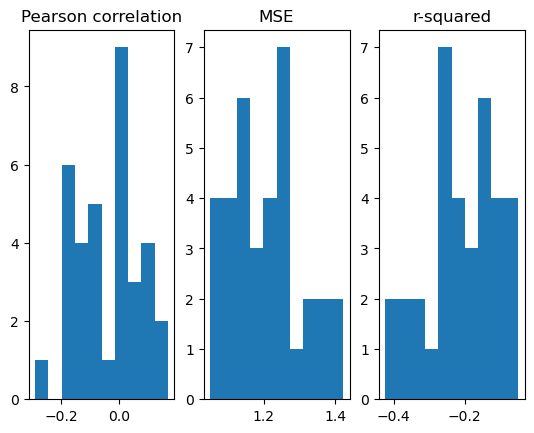

In [13]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): '+dataset_test)
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval[:,2]),3)))

# Save Output

In [14]:
savepath = base_path + '/results/CPM/across/'
result = {'acc':output_acc, 'eval':output_eval}
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
scipy.io.savemat(savepath+'/Sher-FNL_valence.mat',result)

# Load Brain Data Again

In [15]:
import mat73

# Load Sherlock
dynFC_learn = mat73.loadmat(path + '/brain/' + dataset_learn + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
# zscore per feature
dynFC_learn = scipy.stats.zscore(dynFC_learn,2,nan_policy='omit') 
print('  model learn: brain entire feature shape '+str(dynFC_learn.shape))

# Load FNL
dynFC_test = mat73.loadmat(path + '/brain/' + dataset_test + '/a_output/FC/sliding-dynFeat.mat')['dynFeat']
# zscore per feature
dynFC_test = scipy.stats.zscore(dynFC_test,2,nan_policy='omit') 
print('  model test: brain entire feature shape '+str(dynFC_test.shape))

  model learn: brain entire feature shape (16, 7381, 1894)
  model test: brain entire feature shape (35, 7381, 1341)


# Arousal

In [6]:
filepath = base_path + '/results/CPM/within/sherlock/sliding_arousal.mat'
pos_feat = scipy.io.loadmat(filepath)['pos_feat']
neg_feat = scipy.io.loadmat(filepath)['neg_feat']
pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
for i1 in range(nR):
    for i2 in range(nR):
        if pos_feat[i1,i2]<1:
            pos_feat[i1,i2]=0
        if neg_feat[i1,i2]<1:
            neg_feat[i1,i2]=0
print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
all_feat = pos_feat+neg_feat
featid = []
ii = -1
for i1 in range(nR-1):
    for i2 in range(i1+1,nR):
        ii=ii+1
        if all_feat[i1,i2]==1:
            featid.append(ii)

 #pos = 439 , #neg = 154


In [7]:
dynFC_learn = dynFC_learn[:,featid,:]
dynFC_test = dynFC_test[:,featid,:]
print('  model learn: brain selected feature shape '+str(dynFC_learn.shape))
print('  model test : brain selected feature shape '+str(dynFC_test.shape))

  model learn: brain selected feature shape (16, 593, 1894)
  model test : brain selected feature shape (35, 593, 1341)


In [8]:
train_feat = np.transpose(dynFC_learn,(1,0,2))
train_feat = np.reshape(train_feat,(train_feat.shape[0],train_feat.shape[1]*train_feat.shape[2]))

train_arousal = []
for sub in range(learn_nsubj):
    train_arousal.append(arousal_learn)
train_arousal = np.asarray(train_arousal)
train_arousal = np.reshape(train_arousal, (train_arousal.shape[0])*train_arousal.shape[1])

# if several TRs are removed
rmtr_train = []
for tm in range(train_feat.shape[1]):
    if np.all(np.isnan(train_feat[:,tm])):
        rmtr_train.append(tm)
rmtr_train = np.asarray(rmtr_train)
if len(rmtr_train)>0:
    train_feat = np.delete(train_feat,rmtr_train,1)
    train_arousal = np.delete(train_arousal,rmtr_train,0)

In [9]:
nanidx = []
for ft in range(train_feat.shape[0]):
    if np.any(np.isnan(train_feat[ft,:])):
        nanidx.append(ft)
for subj in range(dynFC_test.shape[0]):
    for ft in range(dynFC_test.shape[1]):
        if np.any(np.isnan(dynFC_test[subj,ft,:])):
            nanidx.append(ft)

nanidx = np.unique(nanidx)
print('NaN = '+str(nanidx))

if len(nanidx)>0:
    train_feat = np.delete(train_feat,nanidx,0)
    dynFC_test = np.delete(dynFC_test,nanidx,1)

NaN = []


# Support Vector Regression with non-linear Kernel

In [10]:
print('SVR prediction with model learned from '+str(dataset_learn))
print('  train feature   : '+str(train_feat.T.shape))
print('  train arousal: '+str(train_arousal.shape))

clf = []
clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(train_feat.T, train_arousal)
print('Training done!')

SVR prediction with model learned from sherlock
  train feature   : (30304, 593)
  train arousal: (30304,)
Training done!


In [11]:
output_acc, output_eval = [], []
for test_sub in range(test_nsubj):
    test_feat = dynFC_test[test_sub, :, :]
    test_behavior = arousal_test
    
    rmtr_test = []
    for tm in range(test_feat.shape[1]):
        if np.all(np.isnan(test_feat[:, tm])):
            rmtr_test.append(tm)
    rmtr_test = np.asarray(rmtr_test)
    if len(rmtr_test) > 0:
        test_feat = np.delete(test_feat, rmtr_test, 1)
        test_behavior = np.delete(test_behavior, rmtr_test, 0)
    
    predicted = clf.predict(test_feat.T)
    output_acc.append(predicted)
    
    # evaluate
    pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
    mse = metrics.mean_squared_error(test_behavior, predicted)
    rsq = metrics.r2_score(test_behavior, predicted)
    output_eval.append([pearsonr[0], mse, rsq])
    
    print(' subj ' + str(test_sub + 1) + ' / ' + str(test_nsubj) + ': pearson r=' + str(
            np.round(pearsonr[0], 3)), ', mse=' + str(np.round(mse, 3)) + ', rsq=' + str(np.round(rsq, 3)))
    print('              (train) ft ' + str(train_feat.shape[1]) + ', beh ' + str(train_arousal.shape[0]) +
              ', (test) ft ' + str(test_feat.shape[1]) + ', beh ' + str(test_behavior.shape[0]))
    
output_acc, output_eval = np.asarray(output_acc), np.asarray(output_eval)

 subj 1 / 35: pearson r=0.49 , mse=0.759, rsq=0.24
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 2 / 35: pearson r=0.229 , mse=1.007, rsq=-0.008
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 3 / 35: pearson r=0.348 , mse=0.894, rsq=0.105
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 4 / 35: pearson r=0.345 , mse=0.908, rsq=0.091
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 5 / 35: pearson r=0.369 , mse=0.868, rsq=0.132
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 6 / 35: pearson r=0.126 , mse=1.06, rsq=-0.061
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 7 / 35: pearson r=0.232 , mse=0.96, rsq=0.04
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 8 / 35: pearson r=0.198 , mse=0.999, rsq=-0.0
              (train) ft 30304, beh 30304, (test) ft 1341, beh 1341
 subj 9 / 35: pearson r=0.002 , mse=

Prediction result (mean of cross-validations): FNL
 pearson r = 0.27
 MSE       = 0.954
 r-squared = 0.046


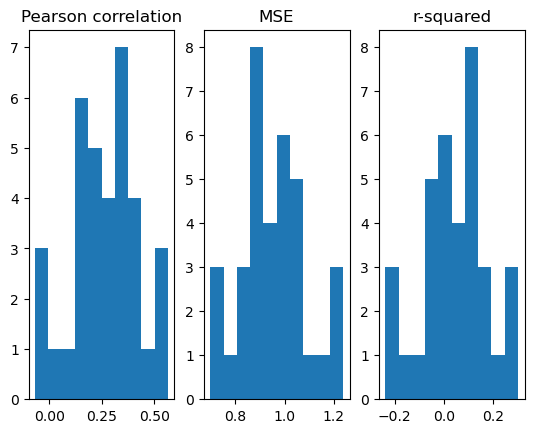

In [12]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): '+dataset_test)
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval[:,2]),3)))

In [24]:
savepath = base_path + '/results/CPM/across/'
result = {'acc':output_acc, 'eval':output_eval}
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
scipy.io.savemat(savepath+'/Sher-FNL_arousal.mat',result)